## Anomaly Detection with Trend-Based Linear Regression (Time Series Data)

#### Objective
Develop a robust anomaly detection system that:
1. Identifies unexpected spikes/drops in time series data
2. Learns normal patterns from historical trends
3. Provides visual and statistical evidence for anomalies
4. Validates new data points against learned patterns

#### Business Use cases
1. **Financial Monitoring**: Detect unusual transactions or revenue fluctuations
2. **IT Operations**: Identify abnormal server metrics or traffic patterns  
3. **Manufacturing**: Spot defects in production line sensor data
4. **Inventory Management**: Catch unexpected changes in stock levels

#### Implementation Details/Flow
1. **Data Load and cleanup**
2. **Trend Modeling**: Fit linear regression to 7-day rolling window to compute expected value
3. **Anomaly Scoring**: Calculate deviation score: |actual - expected| / standard deviation
4. **Anomaly Flagging**: Flag anomalies if deviation score > 3.0
5. **New Data Check**: Validate new data by computing deviation score against recent trend
6. **Visualization**: Plot time series with actual values, trend, and anomaly markers in Jupyter
7. **Reporting**: Report anomalies in last 7 days and latest value status

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uuid

## 2. Load and Prepare Data

Lets ensure the input data is properly formatted and sorted chronologically for trend analysis.

In [2]:
def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['business_date'] = pd.to_datetime(df['business_date'], format='%Y%m%d')
    df = df.sort_values('business_date')
    return df

## 3. Detect Trend-Based Anomalies

Below function added to detect anomalies by fitting a linear trend over a rolling window and flagging significant deviations.
We identify data points that deviate from the expected trend, add columns for expected values, deviation scores, and anomaly flags.

In [3]:
def detect_trend_anomalies(df: pd.DataFrame, window: int = 7, deviation_threshold: float = 3.0) -> pd.DataFrame:
    """
    Detects anomalies based on deviation from recent linear trend.
    Flags as anomaly if the value deviates significantly from expected value based on rolling trend.
    """
    df = df.copy()
    df['expected'] = np.nan
    df['deviation'] = np.nan
    df['is_anomaly'] = False

    for i in range(window, len(df)):
        recent = df.iloc[i - window:i]
        x = np.arange(window)
        y = recent['row_count'].values

        # Linear regression to fit recent trend
        m, c = np.polyfit(x, y, 1)
        expected = m * window + c  # prediction for the next (i-th) point

        actual = df.iloc[i]['row_count']
        deviation = abs(actual - expected)

        std_dev = np.std(y) or 1.0
        deviation_score = deviation / std_dev

        df.at[df.index[i], 'expected'] = expected
        df.at[df.index[i], 'deviation'] = deviation_score
        df.at[df.index[i], 'is_anomaly'] = deviation_score > deviation_threshold

    return df

## 4. Check a New Value Against the Trend

Here we evaluate if a new data point deviates significantly from the recent trend. This allows real-time checking of new values against the established trend, useful for monitoring incoming data.

In [4]:
def check_new_value_by_trend(new_value: float, recent_data: pd.DataFrame, window: int = 7, threshold: float = 3.0) -> bool:
    """Checks if a new value breaks recent trend-based expectation."""
    if len(recent_data) < window:
        return False

    recent = recent_data[-window:]
    x = np.arange(window)
    y = recent['row_count'].values

    m, c = np.polyfit(x, y, 1)
    expected = m * window + c
    std_dev = np.std(y) or 1.0
    deviation = abs(new_value - expected)
    score = deviation / std_dev

    print(f"Trend check: expected={expected:.2f}, new={new_value}, deviation_score={score:.2f}")
    return score > threshold

## 5. Visualize Anomalies

lets see what machine sees.<br> lets plot the data, expected trend, and anomalies.

In [5]:
def plot_trend_anomalies(df: pd.DataFrame):
    """Plot with trend-based anomaly flags and display in notebook."""
    plt.figure(figsize=(10, 6))
    plt.plot(df['business_date'], df['row_count'], label='Row Count')
    plt.plot(df['business_date'], df['expected'], linestyle='--', label='Expected (Trend)', color='orange')
    plt.scatter(df[df['is_anomaly']]['business_date'], df[df['is_anomaly']]['row_count'],
                color='red', label='Anomalies', marker='x')
    plt.xlabel('Business Date')
    plt.ylabel('Row Count')
    plt.title('Trend-Based Anomaly Detection')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 6. Generate Anomaly Report

Lets produce a text report detailing recent anomalies and whether the latest value is an anomaly, for easy interpretation and maybe send over an email.

In [6]:
def generate_anomaly_report(df: pd.DataFrame, window: int = 7, threshold: float = 3.0) -> str:
    """
    Generate a summary report:
    1. Anomalies in last 7 days
    2. Whether the latest value is an anomaly
    """
    report_lines = []

    # Latest date in data
    latest_date = df['business_date'].max()
    last_7_days = latest_date - pd.Timedelta(days=7)
    
    # 1. Anomalies in last 7 days
    recent_anomalies = df[(df['is_anomaly']) & (df['business_date'] > last_7_days)]
    report_lines.append("**Anomalies Detected in Last 7 Days**")
    if not recent_anomalies.empty:
        for _, row in recent_anomalies.iterrows():
            report_lines.append(
                f" - {row['business_date'].date()} | Value: {row['row_count']} | Expected: {int(row['expected'])} | Deviation Score: {row['deviation']:.2f}"
            )
    else:
        report_lines.append(" - No anomalies detected in the last 7 days.")

    # 2. Check if latest value is anomaly
    latest_row = df[df['business_date'] == latest_date].iloc[0]
    is_latest_anomaly = latest_row['is_anomaly']
    report_lines.append("\n**Latest Value Check**")
    report_lines.append(
        f"Latest date: {latest_date.date()} | Value: {latest_row['row_count']} | Expected: {int(latest_row['expected'])} | Deviation Score: {latest_row['deviation']:.2f}"
    )
    report_lines.append(
        f"Status: {'Anomaly Detected' if is_latest_anomaly else 'Normal'}"
    )

    return "\n".join(report_lines)

## 7. Run the Full Workflow

Lets execute the complete pipeline to load data, detect anomalies, generate a report for a dummy trend file

====== Anomaly Report ======
**Anomalies Detected in Last 7 Days**
 - 2025-04-22 | Value: 1500000 | Expected: 1077154 | Deviation Score: 415.94

**Latest Value Check**
Latest date: 2025-04-25 | Value: 1178223 | Expected: 1198928 | Deviation Score: 0.14
Status: Normal


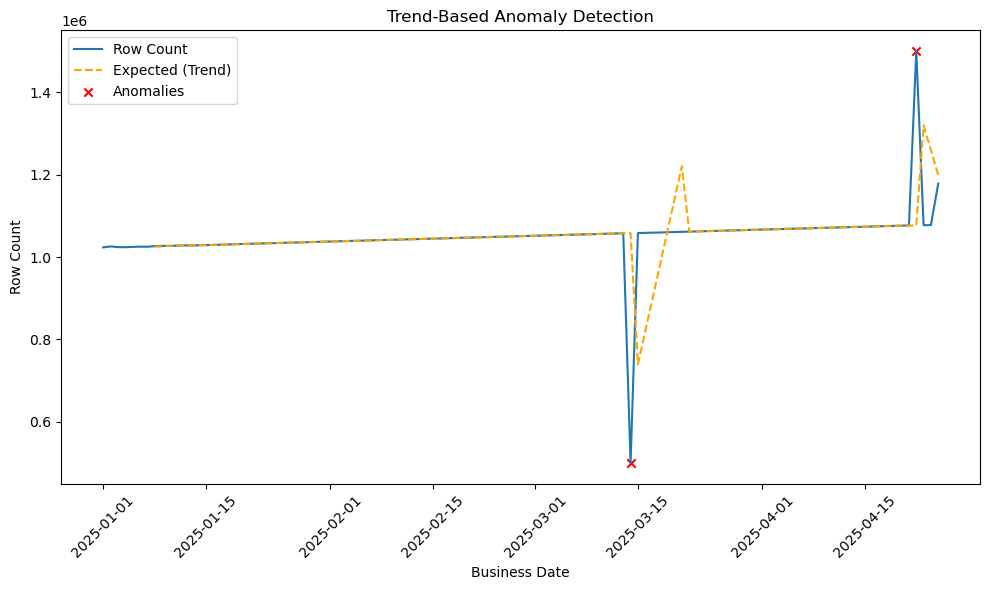

In [7]:
df = load_data("trends3.csv")
df_anomalies = detect_trend_anomalies(df, window=7, deviation_threshold=3.0)
report = generate_anomaly_report(df_anomalies, window=7, threshold=3.0)
print("====== Anomaly Report ======")
print(report)
plot_trend_anomalies(df_anomalies)

Lets run above functionalites on another dummy data file

====== Anomaly Report ======
**Anomalies Detected in Last 7 Days**
 - 2025-04-23 | Value: 380 | Expected: 402 | Deviation Score: 4.51

**Latest Value Check**
Latest date: 2025-04-25 | Value: 385 | Expected: 384 | Deviation Score: 0.02
Status: Normal


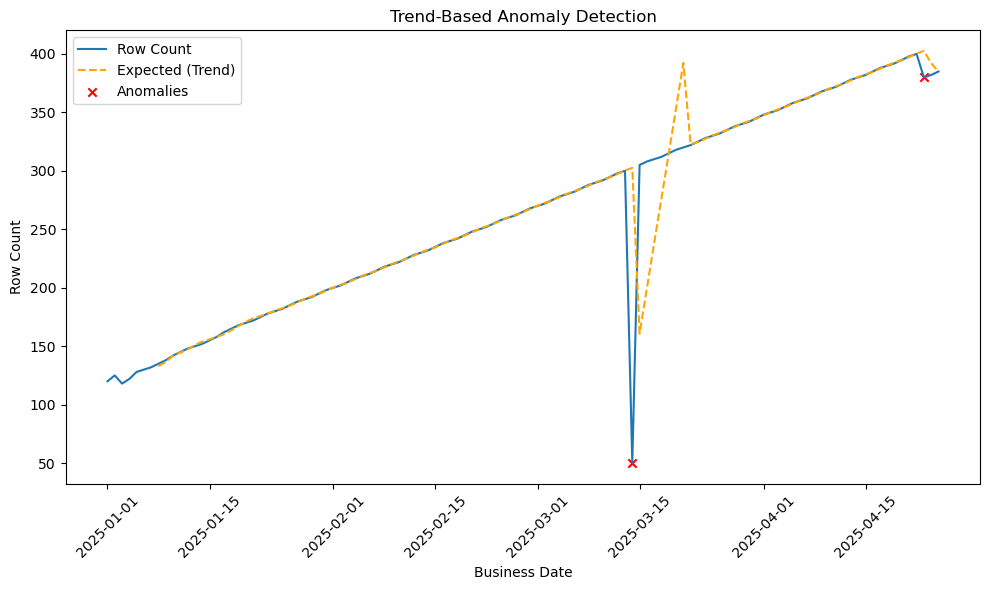

In [8]:
df = load_data("trends2.csv")
df_anomalies = detect_trend_anomalies(df, window=7, deviation_threshold=3.0)
report = generate_anomaly_report(df_anomalies, window=7, threshold=3.0)
print("====== Anomaly Report ======")
print(report)
plot_trend_anomalies(df_anomalies)

Works well !!